# Hidden Markov Models (HMMs) and Bayes Net
 


## 1. HMM model

Implement in `hmmlearn` the HMM model from theory-problem below, and verify your answers.

Real DNA sequences are inhomogeneous and can be described by a HMM with hidden states representing different types of nucleotide composition. Consider an HMM that includes two hidden states $H$ and $L$ for higher and lower $C,G$ content, respectively. Initial probabilities for both $H$ and $L$ are equal to 0.5, while transition probabilities are as follows: $$p_{H,H}= 0.5, p_{H,L} = 0.5, p_{L,L} = 0.6, p_{L,H} = 0.4$$ Nucleotides $T, C, A, G$ are emitted from states $H$ and $L$ with probabilities 0.2, 0.3, 0.2, 0.3, and 0.3, 0.2, 0.3, 0.2, respectively. \
a. Calculate the evidence for the toy sequence $\mathbf{o}_{1:3}=(GGA)$. \
b. Calculate the conditional distribution $p(x_2=i|\mathbf{o}_{1:3}=(GGA)),\; i=H,L$ \
c. Find the most likely sequence of hidden states for the sequence $\mathbf{o}_{1:3}=(GGA)$.  

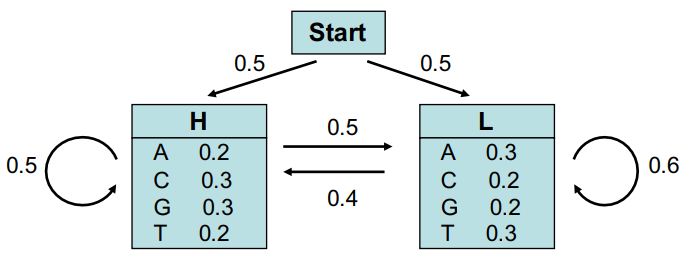



In [1]:
#!pip install hmmlearn # run once if hmmlearn is not installed
from hmmlearn import hmm;import numpy as np

# Define the HMM model parameters
Num_HiddenStates= 2 
start_prob = np.array([0.5, 0.5])  # Initial probabilities for state H=0 and L=1
trans_prob = np.array([[0.5, 0.5],  # Transition probabilities
                       [0.4, 0.6]])
emission_prob = np.array([[0.2, 0.3, 0.3, 0.2],   # Emission probabilities for H
                          [0.3, 0.2, 0.2, 0.3]])  # Emission probabilities for L
                                                  # Emission states: A=0, C=1, G=2, T=3
# Create the HMM model
model = hmm.CategoricalHMM(n_components=Num_HiddenStates)
model.startprob_ = start_prob; model.transmat_ = trans_prob; model.emissionprob_ = emission_prob

# Define the observed sequence (GGA)
observed_sequence = np.array([[2, 2, 0]]).T  # G=2, G=2, A=0

# q1.Calculate the log likelihood (evidence) of the observed sequence
log_e = model.score( observed_sequence )
print( f"log-evidence = {log_e} \n evidence = {np.exp(log_e)}" )

# q2.Calculate the posterior probabilities
posterior_probs = model.predict_proba(observed_sequence)
print(f"Posterior Probabilities:\n{posterior_probs}")

# q3.Find the most likely sequence of hidden states
hidden_states = model.predict(observed_sequence)
print(f"Most Likely Hidden States: {hidden_states}")

log-evidence = -4.157603901861291 
 evidence = 0.015645000000000003
Posterior Probabilities:
[[0.60882071 0.39117929]
 [0.55129434 0.44870566]
 [0.35858102 0.64141898]]
Most Likely Hidden States: [0 0 1]


## 2. Bayes Net
Consider the following binary Bayes net from class:\
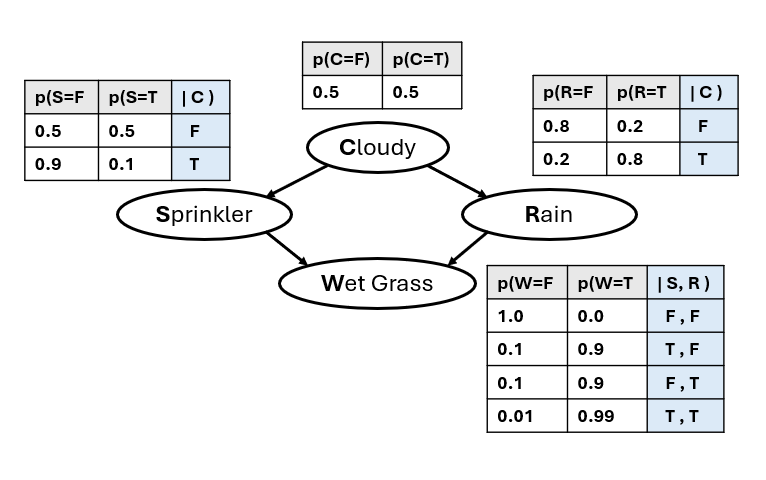 \
The `pymc` code below implements this probabilistic model, by employing intermediate variables ($R_p,S_p,W_p$) to model the conditional Bernoulli probability of each variable.


### 2.1. Build Model: Conditional Bernoulli ( Intermediate variable) - use pymc

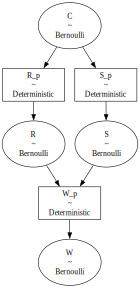

In [2]:
import numpy as np; import pymc as pm; from pymc import Model

with Model() as my_model:  
    C = pm.Bernoulli("C", p = 0.5 ) 
    ## P(S=T|C=T)=0.1: If C=1, then S_p=0.1 /// Otherwise if C=0, then P(S=T|C=F)=0.5 -> S_p=0.5
    S_p = pm.Deterministic('S_p', pm.math.switch(C, 0.1, 0.5))
    S = pm.Bernoulli('S', S_p)
    R_p = pm.Deterministic('R_p', pm.math.switch(C, 0.8, 0.2))
    R = pm.Bernoulli('R', p = R_p)
    W_p = pm.Deterministic('W_p', pm.math.switch(R, pm.math.switch(S, 0.99, 0.9), pm.math.switch(S, 0.9, 0)))
    W = pm.Bernoulli('W', W_p)

#import graphviz;import matplotlib as plt
graph = pm.model_to_graphviz(my_model);graph.graph_attr.update(size='8,4');graph

### 2.2. Sampling from Model 
Use `pymc.sample()` to draw a posterior sample of $N=5,000$ (in 1 chain) from the model. Plot the resulting marginal sample using `pymc.plot_posterior()`, and compare the the histogram you get for $W$ to the exact *marginal* probability of $P(W=T)=0.6471$ that we derived in class.

Sequential sampling (1 chains in 1 job)
BinaryGibbsMetropolis: [C, S, R, W]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'C'}>, <Axes: title={'center': 'R'}>,
        <Axes: title={'center': 'R_p'}>],
       [<Axes: title={'center': 'S'}>, <Axes: title={'center': 'S_p'}>,
        <Axes: title={'center': 'W'}>],
       [<Axes: title={'center': 'W_p'}>, <Axes: >, <Axes: >]],
      dtype=object)

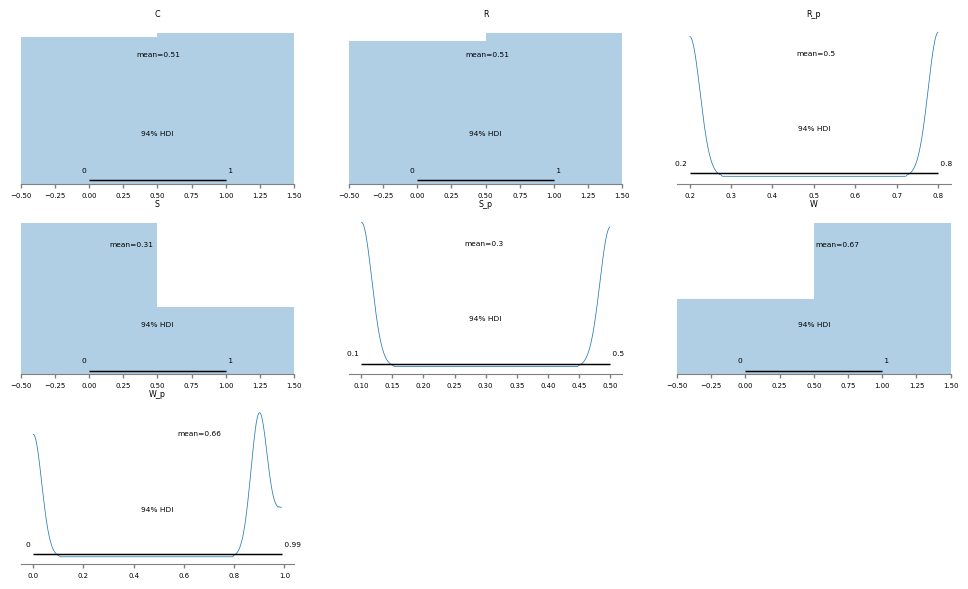

In [3]:
import pymc as pm; from pymc import Model
post_sample = pm.sample( model = my_model, draws = 5000, chains = 1, random_seed = 12345 )

pm.plot_posterior(post_sample, figsize=(12, 7), textsize=5)

In [4]:
# The mean for W is 0.646 which is close to the theoretical value of 0.6471
# You can also use the following code to get the summary statistics
import arviz as az
az.summary(post_sample, kind="stats")

,mean,sd,hdi_3%,hdi_97%
C,0.508,0.500,0.0,1.00
R,0.514,0.500,0.0,1.00
R_p,0.505,0.300,0.2,0.80
S,0.307,0.461,0.0,1.00
S_p,0.297,0.200,0.1,0.50
W,0.669,0.470,0.0,1.00
W_p,0.664,0.406,0.0,0.99


### 2.3. Rebuild Model: Given fixed value (observations)
Modify the model to *fix* the value of the variable $W$ to $0/False$, and use `pymc.sample()` again to draw a posterior sample of $N=5,000$ (in 1 chain) from the model. Plot the posterior sample and compare the sample mean you get for $C$ to the exact posterior probability of $P(C=T|W=F)=0.361$ that was derived in class.

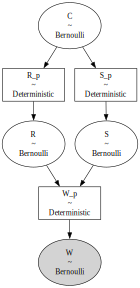

In [5]:
import numpy as np;import pymc as pm;from pymc import Model

with Model() as my_post_model:      
    C = pm.Bernoulli("C", p = 0.5 ) 
    S_p = pm.Deterministic('S_p', pm.math.switch(C, 0.1, 0.5))
    S = pm.Bernoulli('S', S_p)
    R_p = pm.Deterministic('R_p', pm.math.switch(C, 0.8, 0.2))
    R = pm.Bernoulli('R', p = R_p)
    W_p = pm.Deterministic('W_p', pm.math.switch(R, pm.math.switch(S, 0.99, 0.9), pm.math.switch(S, 0.9, 0)))
    W = pm.Bernoulli('W', W_p, observed = 0)

#import graphviz;import matplotlib as plt
graph = pm.model_to_graphviz(my_post_model);graph.graph_attr.update(size='8,4');graph


Sequential sampling (1 chains in 1 job)
BinaryGibbsMetropolis: [C, S, R]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'C'}>, <Axes: title={'center': 'R'}>,
        <Axes: title={'center': 'R_p'}>],
       [<Axes: title={'center': 'S'}>, <Axes: title={'center': 'S_p'}>,
        <Axes: title={'center': 'W_p'}>]], dtype=object)

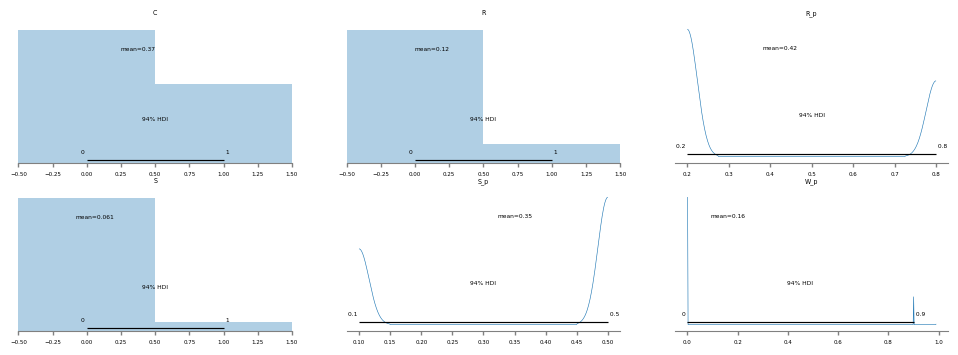

In [6]:
import pymc as pm; from pymc import Model
post_sample = pm.sample(model = my_post_model, draws = 5000, chains = 1 )

pm.plot_posterior(post_sample, figsize=(12, 4), textsize=4)

In [7]:
import arviz as az
az.summary( post_sample, kind="stats")
# The conditional mean of C|W=F is 0.35 which is close to the theoretical value of 0.361 
# (and different from the unconditional marginal probability or P(C=T)=0.5)

,mean,sd,hdi_3%,hdi_97%
C,0.373,0.484,0.0,1.0
R,0.124,0.329,0.0,1.0
R_p,0.424,0.290,0.2,0.8
S,0.061,0.239,0.0,1.0
S_p,0.351,0.193,0.1,0.5
W_p,0.164,0.348,0.0,0.9
